Key Takeaways:
1. States are not represented equally in the data - 4 states represent ~50% of the data while rest of the 50% is represented by 19 states
2. 
    

In [49]:
# Importing libararies
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
# Defining path to district csv
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
print(parent_dir)
data_path = os.path.join(parent_dir, 'data/districts_info.csv')
print(data_path)

/Users/eshan23/eshanprashar_git_profile/kaggle_practice/L1_education/covid_edtech_usage
/Users/eshan23/eshanprashar_git_profile/kaggle_practice/L1_education/covid_edtech_usage/data/districts_info.csv


In [9]:
# Import district data
df_districts = pd.read_csv(data_path)
df_districts.info()
df_districts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state                     176 non-null    object
 2   locale                    176 non-null    object
 3   pct_black/hispanic        176 non-null    object
 4   pct_free/reduced          148 non-null    object
 5   county_connections_ratio  162 non-null    object
 6   pp_total_raw              118 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB


,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Remove districts which cannot be mapped to states
df_districts = df_districts.dropna(subset=['state'])

# Examine count of districts per state
print('Total districts:', df_districts.shape[0])
df_districts['state'].value_counts()

Total districts: 176


state
Connecticut             30
Utah                    29
Massachusetts           21
Illinois                18
California              12
Ohio                    11
New York                 8
Indiana                  7
Washington               6
Missouri                 6
Virginia                 4
North Carolina           4
Wisconsin                3
District Of Columbia     3
New Jersey               2
Texas                    2
Tennessee                2
New Hampshire            2
Michigan                 2
Minnesota                1
Arizona                  1
Florida                  1
North Dakota             1
Name: count, dtype: int64

In [23]:
# Read the engagement data and check count of rows by state
data_path = os.path.join(parent_dir, 'data/engagement_data_filtered.parquet')
df_engagement = pd.read_parquet(data_path)
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11691587 entries, 0 to 22324188
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              object 
 1   lp_id             int64  
 2   pct_access        float64
 3   engagement_index  float64
 4   district_id       int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 535.2+ MB


In [26]:
# Merge the engagement data with the district data
df_engagement_districts = pd.merge(df_engagement, df_districts, how='left', on='district_id')

397378.3043478261


state
Connecticut             1520577
Utah                    1278833
Illinois                1172850
Massachusetts           1142106
California               673542
Ohio                     608886
Missouri                 479741
Washington               359988
Indiana                  352358
Virginia                 317847
North Carolina           241493
New York                 194235
Wisconsin                117480
Michigan                 111971
New Jersey               110904
Florida                  100243
District Of Columbia      98998
Tennessee                 84610
Texas                     76879
New Hampshire             57447
Arizona                   20506
Minnesota                 17003
North Dakota               1204
Name: count, dtype: int64

In [42]:
# Check count of rows by state
print(df_engagement_districts['state'].value_counts().mean())
state_wise_aggregates = df_engagement_districts.groupby('state').agg({'district_id': 'nunique','engagement_index':'count'}).reset_index().sort_values(by='district_id', ascending=False)
state_wise_aggregates

475975.84210526315


,state,district_id,engagement_index
1,Connecticut,30,1520577
15,Utah,29,1278833
6,Massachusetts,21,1142106
4,Illinois,18,1172850
0,California,12,673542
12,Ohio,11,608886
10,New York,8,194235
5,Indiana,7,352358
17,Washington,6,359988
8,Missouri,6,479741


In [28]:
# Let's look at simple descriptive statistics for engagement data: overall and by state
df_engagement_districts['engagement_index'].describe().round(2)
# We can see that the standard deviation is too high, which indicates we may have to remove outliers and/or apply sampling techniques

count    11691587.00
mean          207.25
std          1928.82
min             0.00
25%             0.18
50%             2.28
75%            20.18
max        152747.07
Name: engagement_index, dtype: float64

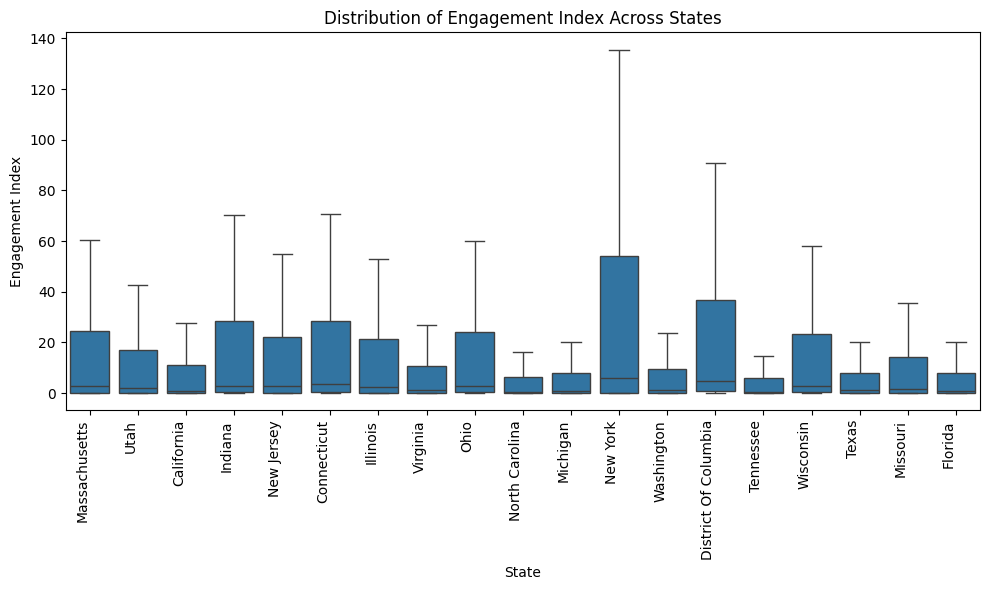

In [43]:
# Let's draw a box and whisker plot to visualize the distribution of engagement index across states
plt.close()
plt.figure(figsize=(10, 6))
sns.boxplot(x='state', y='engagement_index', data=df_engagement_districts, showfliers=False)

# Rotate the x labels for better readability
plt.xticks(rotation=90, ha='right')

# Add title and labels
plt.title('Distribution of Engagement Index Across States')
plt.xlabel('State')
plt.ylabel('Engagement Index')

# Show the plot
plt.tight_layout()
plt.show()

### From the plot above, we see that [North Dakota, Arizona and New Hampshire] have the largest spread of values. These states also have the lowest number of observations (along with Minnesota); so we have a good reason to remove them from our dataset.

In [41]:
# Removing data for states North Dakota, Arizona and New Hampshire
states_to_remove = ['North Dakota', 'Arizona', 'New Hampshire', 'Minnesota']
df_engagement_districts = df_engagement_districts[~df_engagement_districts['state'].isin(states_to_remove)]

# Now check the overall engagement index and examine the box plot 
df_engagement_districts['engagement_index'].describe().round(2)

count    11595427.00
mean          205.46
std          1918.02
min             0.00
25%             0.18
50%             2.25
75%            19.95
max        152747.07
Name: engagement_index, dtype: float64

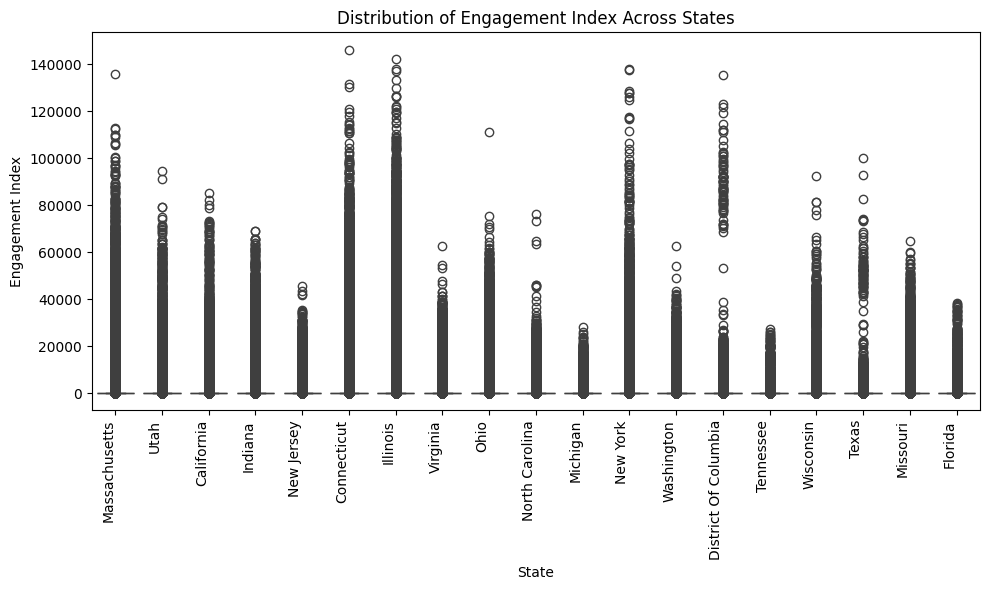

In [54]:
# Drawing spread of observations across states to examine high standard deviatons
plt.close()
plt.figure(figsize=(10, 6))
sns.boxplot(x='state', y='engagement_index', data=df_engagement_districts)

# Rotate the x labels for better readability
plt.xticks(rotation=90, ha='right')

# Add title and labels
plt.title('Distribution of Engagement Index Across States')
plt.xlabel('State')
plt.ylabel('Engagement Index')

# Show the plot
plt.tight_layout()
plt.show()

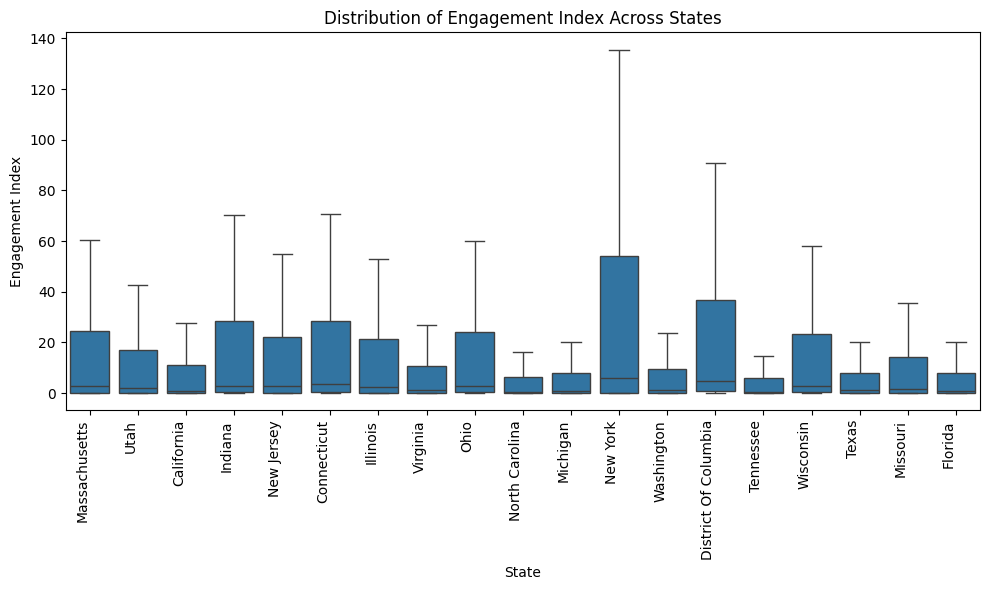

In [44]:
# Let's draw a box and whisker plot to visualize the distribution of engagement index across states
plt.close()
plt.figure(figsize=(10, 6))
sns.boxplot(x='state', y='engagement_index', data=df_engagement_districts, showfliers=False)

# Rotate the x labels for better readability
plt.xticks(rotation=90, ha='right')

# Add title and labels
plt.title('Distribution of Engagement Index Across States')
plt.xlabel('State')
plt.ylabel('Engagement Index')

# Show the plot
plt.tight_layout()
plt.show()

In [47]:
# Sampling data to reduce the standard deviation

def calculate_required_sample_sizes(df, sampling_column, value_column, confidence_level, Z, margin_of_error_percentage=0.02):
    # Step 1: Group by the sampling column (e.g., state) and calculate necessary statistics
    state_wise_aggregates = df.groupby(sampling_column).agg(
        population_count=(value_column, 'count'),
        standard_deviation=(value_column, 'std'),
        average_engagement_index=(value_column, 'mean')
    ).reset_index()
    
    # Step 2: Calculate the margin of error based on the average engagement index
    state_wise_aggregates['margin_of_error'] = state_wise_aggregates['average_engagement_index'] * margin_of_error_percentage
    
    # Step 3: Calculate the required sample sizes
    state_wise_aggregates['required_sample_size'] = state_wise_aggregates.apply(
        lambda row: np.ceil((Z * row['standard_deviation'] / row['margin_of_error']) ** 2) if pd.notnull(row['standard_deviation']) else np.nan,
        axis=1
    )
    
    # Step 4: Return the DataFrame with required sample sizes
    return state_wise_aggregates[[sampling_column, 'population_count', 'average_engagement_index', 'standard_deviation', 'margin_of_error', 'required_sample_size']]

In [52]:
# Define the parameters for sample size calculation
confidence_level = 0.95
Z = 1.96

# Call the function to calculate required sample sizes
required_sample_sizes_df = calculate_required_sample_sizes(
    df=df_engagement_districts,
    sampling_column='state',
    value_column='engagement_index',
    confidence_level=confidence_level,
    Z=Z,
    margin_of_error_percentage=0.02
)

# Display the result
print(required_sample_sizes_df.to_string(index=False, justify='center'))

       state          population_count  average_engagement_index  standard_deviation  margin_of_error  required_sample_size
          California       673542              131.090179            1284.597436         2.621804            922245.0      
         Connecticut      1520577              279.718637            2484.917908         5.594373            757938.0      
District Of Columbia        98998              327.082148            2820.881987         6.541643            714346.0      
             Florida       100243              108.480557            1064.885346         2.169611            925453.0      
            Illinois      1172850              259.201274            2598.234897         5.184025            965017.0      
             Indiana       352358              257.594330            2003.593647         5.151887            581031.0      
       Massachusetts      1142106              226.976027            2118.343879         4.539521            836537.0      
        

### Note on anonymizing data:  
**Source:** https://onlinelibrary.wiley.com/doi/full/10.1002/spe.2812

1. The key tradeoff is between risk and utility. If risk is governed by clear policy (e.g. GDPR), rule setting can be easier
2. Standard practices are:
    - Sampling
    - Aggregation (assign mean value)
    - Suppression
    - Masking
    - Categorization
    - Generalization
3. Algorithms exists that apply one or more of these methods to chunks of data and calculate risk and utility recursively

In [16]:
# Examining value counts to assign interpretable values
# Column 'pct_black/hispanic'
df_districts['pct_black/hispanic'].value_counts()

pct_black/hispanic
[0, 0.2[      116
[0.2, 0.4[     24
[0.4, 0.6[     17
[0.6, 0.8[     11
[0.8, 1[        8
Name: count, dtype: int64

In [17]:
# # Examining value counts to assign interpretable values
# Column 'pct_free/reduced'
df_districts['pct_free/reduced'].value_counts()

pct_free/reduced
[0.2, 0.4[    48
[0, 0.2[      46
[0.4, 0.6[    37
[0.6, 0.8[    13
[0.8, 1[       4
Name: count, dtype: int64

In [18]:
# Examining value counts to assign interpretable values
# Column 'county_connections_ratio'
df_districts['county_connections_ratio'].value_counts()

county_connections_ratio
[0.18, 1[    161
[1, 2[         1
Name: count, dtype: int64

In [19]:
# Examining value counts to assign interpretable values
# Column 'pp_total_raw'
df_districts['pp_total_raw'].value_counts()

pp_total_raw
[8000, 10000[     30
[10000, 12000[    17
[14000, 16000[    15
[12000, 14000[    15
[6000, 8000[      13
[16000, 18000[    13
[18000, 20000[     8
[20000, 22000[     2
[22000, 24000[     2
[4000, 6000[       2
[32000, 34000[     1
Name: count, dtype: int64